# Amazon Video Games Recommendation System

## Business Understanding

In order to enhance the customer’s shopping experience, the online shopping sites usually have their own recommendation system to personalize each customer's shopping experience. Same as Amazon, as one of the biggest online retailers, Amazon has large number of products and variety of shopping categories. Hence, recommendation system becomes a powerful tool that can guide customers to the potential products they are looking for in a time saving way. Just like people who want to shop video games on Amazon, a good recommendation system could guide customers to their potentially interested games among thousands of products in a quick and easy way. Besides, Amazon’s variety of product categories can provide customers more than just games, but also accessories. For example, customers may also need a controller or headphone. We could deploy the recommendation system at checkout page as a reminder and motive customers to purchase more. Hence, a great recommendation system could make Amazon to be a one-stop shop for every gamer.

In [106]:
import json
import gzip
import re
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from surprise import Reader, Dataset, accuracy, NormalPredictor, BaselineOnly, KNNBasic, SVD, SVDpp
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

## Data Understanding

The data I used for the project is originally from Amazon.com and collected by department of computer science from UCSD. Due to the large size of the datasets, I’m not able to upload my data to this GitHub repository, but here is the link to access the data I used (The latest version data link was down at the time when editing this README. I'll keep tracking the link and push the right link when it back to work) The dataset contains user review from May 1996 to Oct 2018 and each item have at least 5 reviews (5-core). Plus, a metadata includes descriptions, price, sales-rank, brand info of video games.

Both datasets are gzip JSON files, need compress them when read the data.

In [2]:
df_review = pd.read_json('Data/Video_Games_5.json.gz', compression='gzip', lines=True)

In [3]:
df_prod = pd.read_json('Data/meta_Video_Games.json.gz', compression='gzip', lines=True)

In [4]:
df_review.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [5]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497577 entries, 0 to 497576
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         497577 non-null  int64 
 1   verified        497577 non-null  bool  
 2   reviewTime      497577 non-null  object
 3   reviewerID      497577 non-null  object
 4   asin            497577 non-null  object
 5   reviewerName    497501 non-null  object
 6   reviewText      497419 non-null  object
 7   summary         497468 non-null  object
 8   unixReviewTime  497577 non-null  int64 
 9   vote            107793 non-null  object
 10  style           289237 non-null  object
 11  image           3634 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 42.2+ MB


In [6]:
df_prod.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Video Games, PC, Games]",,[],,Reversi Sensory Challenger,[],,Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,,,0042000742,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
1,"[Video Games, Xbox 360, Games, </span></span><...",,[Brand new sealed!],,Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],,by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,,"\n\t\t\t\t\t\t\t\t\t\t\t\t<span class=""vertica...",0078764343,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,"[Video Games, Retro Gaming & Microconsoles, Su...",,[],,street fighter 2 II turbo super nintendo snes ...,[],,Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,,$0.72,0276425316,[],[],NaN
3,"[Video Games, Xbox 360, Accessories, Controlle...",,[MAS's Pro Xbox 360 Stick (Perfect 360 Stick) ...,,Xbox 360 MAS STICK,[],,by\n \n MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,,,0324411812,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
4,"[Video Games, PC, Games, </span></span></span>...",,"[Phonics Alive! 3, The Speller teaches student...",,Phonics Alive! 3: The Speller,[],,by\n \n Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,,,0439335310,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


In [7]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84819 entries, 0 to 84818
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         84819 non-null  object
 1   tech1            84819 non-null  object
 2   description      84819 non-null  object
 3   fit              84819 non-null  object
 4   title            84819 non-null  object
 5   also_buy         84819 non-null  object
 6   tech2            84819 non-null  object
 7   brand            84819 non-null  object
 8   feature          84819 non-null  object
 9   rank             84819 non-null  object
 10  also_view        84819 non-null  object
 11  main_cat         84819 non-null  object
 12  similar_item     84819 non-null  object
 13  date             84819 non-null  object
 14  price            84819 non-null  object
 15  asin             84819 non-null  object
 16  imageURL         84819 non-null  object
 17  imageURLHighRes  84819 non-null

First do some data cleaning on metadata.

In [10]:
df_prod['price'].loc[df_prod['price']==''].shape

(25460,)

Drop unnecessary columns. 

In [11]:
df_prod.drop(['tech1', 'fit', 'tech2', 'date', 'price', 'imageURLHighRes', 'details'], axis=1, inplace=True)

In [12]:
#pd.set_option('display.max_colwidth', None)
df_prod.iloc[[1, -1]]

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,asin,imageURL
1,"[Video Games, Xbox 360, Games, </span></span><...",[Brand new sealed!],Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,0078764343,[https://images-na.ssl-images-amazon.com/image...
84818,"[Video Games, PC, Accessories, Gaming Mice]",[<b>Features and Functions:</b> <br>Quick thum...,Zelotes 4000 DPI Programmable Gaming Mouse for...,[],Zelotes,"[Customize DPI Switch: 1000/1500/2000/4000,the...",[>#434 in Computers & Accessories > Computer A...,"[B016ZF77OA, B00GU8W5AE, B00E64DTDQ, B074TF6XV...",Computers,,B01HJEBIAA,[https://images-na.ssl-images-amazon.com/image...


In [13]:
df_prod.head(20)

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,asin,imageURL
0,"[Video Games, PC, Games]",[],Reversi Sensory Challenger,[],Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,0042000742,[https://images-na.ssl-images-amazon.com/image...
1,"[Video Games, Xbox 360, Games, </span></span><...",[Brand new sealed!],Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,0078764343,[https://images-na.ssl-images-amazon.com/image...
2,"[Video Games, Retro Gaming & Microconsoles, Su...",[],street fighter 2 II turbo super nintendo snes ...,[],Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,0276425316,[]
3,"[Video Games, Xbox 360, Accessories, Controlle...",[MAS's Pro Xbox 360 Stick (Perfect 360 Stick) ...,Xbox 360 MAS STICK,[],by\n \n MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,0324411812,[https://images-na.ssl-images-amazon.com/image...
4,"[Video Games, PC, Games, </span></span></span>...","[Phonics Alive! 3, The Speller teaches student...",Phonics Alive! 3: The Speller,[],by\n \n Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,0439335310,[https://images-na.ssl-images-amazon.com/image...
5,"[Video Games, PC, Games, </span></span></span>...",[CD-ROM],Sim City 3000,[],by\n \n Scholastic,[Sim City 3000 CD-ROM],"[>#19,087 in Video Games (See Top 100 in Video...","[B00004T1M7, B00000G16I, B00006GF1U, B0000C0YW...",Video Games,,0439339006,[https://images-na.ssl-images-amazon.com/image...
6,"[Video Games, PC, Games, </span></span></span>...",[],Phonics Alive! 2 The Sound Blender,[],by\n \n Advanced Software Party,[Phonics Alive! 2 The Sound Blender is a new a...,"[>#117,477 in Video Games (See Top 100 in Vide...",[],Video Games,,0439335299,[]
7,"[Video Games, PC, Games, </span></span></span>]",[a scholastic clubs fairs cd rom game],A to Zap,[],by\n \n sunburst,[],"[>#87,937 in Video Games (See Top 100 in Video...",[],Video Games,,0439339960,[https://images-na.ssl-images-amazon.com/image...
8,"[Video Games, PC, Games]",[video game],Need for Speed Porsche Unleashed,[],Electronic Arts,[video game],"[>#51,505 in Video Games (See Top 100 in Video...","[B00004DITL, B000067NP1, B00003W869]",Video Games,,043933702X,[https://images-na.ssl-images-amazon.com/image...
9,"[Video Games, PC, Games, </span></span></span>...",[Grandma Groupers kelp seeds are missing and w...,Freddi Fish and the Case of The Missing Kelp S...,"[B00002S6E5, B000NQI666, B000AQJ4AG, B000FETCF...",by\n \n Humongous Entertainment,"[Like the real world, Freddi Fishs world chang...","[>#58,523 in Video Games (See Top 100 in Video...","[B000FETCF0, B00005BU3M, B00004UCUT, B0009RAVF...",Video Games,,0439339987,[https://images-na.ssl-images-amazon.com/image...


The biggest problem now is the HTMl tags in some of the columns, like '/span', '/n', 'div', etc. Need take out these tags.

In [14]:
# convert each list in category column into one string
df_prod['category'] = [','.join(map(str, l)) for l in df_prod['category']]

In [15]:
# try replace the HTML tag with empty string
re.sub('</span>', '', df_prod['category'][1])

'Video Games,Xbox 360,Games,'

In [16]:
# create a function removes HTML tages
def remove_tags(string):
    exclusionlist = ['</span>','<b>', '</b>', '<br />', '\n', '/n', '</div>', '<div>', '<DIV>', '</DIV>']
    exclusions = '|'.join(exclusionlist)
    result = re.sub(exclusions, '', string)
    return result

In [21]:
# apply the function and remove all HTML tags in category column
df_prod['category'] = df_prod['category'].apply(lambda x : remove_tags(x))

In [22]:
# do the same on description column
df_prod['description'] = [''.join(map(str, l)) for l in df_prod['category']]

In [23]:
df_prod['description'] = df_prod['description'].apply(lambda x: remove_tags(x))

In [24]:
# strip by and \n in front of brand names
df_prod['brand'] = df_prod['brand'].apply(lambda x: re.sub('by', '', x))
df_prod['brand'] = df_prod['brand'].apply(lambda x: re.sub('\n', '', x))

In [26]:
df_prod

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,asin,imageURL
0,"Video Games,PC,Games","Video Games,PC,Games",Reversi Sensory Challenger,[],Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,0042000742,[https://images-na.ssl-images-amazon.com/image...
1,"Video Games,Xbox 360,Games,","Video Games,Xbox 360,Games,",Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,0078764343,[https://images-na.ssl-images-amazon.com/image...
2,"Video Games,Retro Gaming & Microconsoles,Super...","Video Games,Retro Gaming & Microconsoles,Super...",street fighter 2 II turbo super nintendo snes ...,[],Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,0276425316,[]
3,"Video Games,Xbox 360,Accessories,Controllers,J...","Video Games,Xbox 360,Accessories,Controllers,J...",Xbox 360 MAS STICK,[],MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,0324411812,[https://images-na.ssl-images-amazon.com/image...
4,"Video Games,PC,Games,,Grades 2-12,Spelling Pro...","Video Games,PC,Games,,Grades 2-12,Spelling Pro...",Phonics Alive! 3: The Speller,[],Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,0439335310,[https://images-na.ssl-images-amazon.com/image...
...,...,...,...,...,...,...,...,...,...,...,...,...
84814,"Video Games,PlayStation Vita,Digital Games & D...","Video Games,PlayStation Vita,Digital Games & D...",Lego Star Wars: The Force Awakens - PS Vita [D...,[],Warner Bros.,[],"[>#74,224 in Video Games (See Top 100 in Video...",[],Video Games,,B01HJ1521Y,[]
84815,"Video Games,PlayStation 4,Digital Games & DLC,...","Video Games,PlayStation 4,Digital Games & DLC,...",Lego Star Wars: The Force Awakens Season Pass...,[],Warner Bros.,[DLC Requires base game],"[>#62,150 in Video Games (See Top 100 in Video...",[],Video Games,,B01HJ14TTA,[]
84816,"Video Games,PlayStation 4,Digital Games & DLC,...","Video Games,PlayStation 4,Digital Games & DLC,...",The Technomancer - PS4 [Digital Code],[],Focus Home Interactive,[],"[>#94,234 in Video Games (See Top 100 in Video...",[],Video Games,,B01HJ14OT0,[https://images-na.ssl-images-amazon.com/image...
84817,"Video Games,Xbox 360,Accessories,","Video Games,Xbox 360,Accessories,","Repair T8 T6 Tools for XBOX One Xbox 360, YTTL...","[B01KBNB7K2, B06X6JSYPC, B01N6Y0Z7W, B06VXD2W5...",YTTL,[If you want to Replacement you Xbox one /360 ...,"[>#16,087 in Video Games (See Top 100 in Video...","[B01KH25ZY6, B00PG8SU26, B07G122BVS, B016XLTQP...",Video Games,,B01HJC33WS,[https://images-na.ssl-images-amazon.com/image...


I noticed some brands' names are called differently, but they should belong to same game publisher. So far, I found EA Games and Ubisoft Entertainment need to be changed to have consistent publisher name.

In [27]:
df_prod['brand'].loc[df_prod['brand']=='EA Games']

5792     EA Games
6796     EA Games
10441    EA Games
10919    EA Games
10938    EA Games
18700    EA Games
19704    EA Games
23349    EA Games
23827    EA Games
23846    EA Games
28068    EA Games
Name: brand, dtype: object

In [144]:
df_prod.loc[df_prod['brand']=='Ubisoft']

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,asin,imageURL,is_PC,is_Xbox360,is_Xboxone,is_PS4,is_PS3,is_Wii,is_microconsloes,is_accesssories
38,"[Video Games, PC, Games]","Video Games,PC,Games",Anno 2070,[],Ubisoft,[A new era: while adhering to the fundamentals...,"[>#30,230 in Video Games (See Top 100 in Video...","[B013F0IP1C, B00JDP1AWU, B00XR3YC2E, B001AWMCM...",Video Games,,0700026657,[https://images-na.ssl-images-amazon.com/image...,1,0,0,0,0,0,0,0
1174,"[Video Games, Retro Gaming & Microconsoles, Ni...","Video Games,Retro Gaming & Microconsoles,Ninte...",All Star Tennis '99,[],Ubisoft,[],"[>#75,522 in Video Games (See Top 100 in Video...",[],Video Games,,B000028U2B,[],0,0,0,0,0,0,1,0
1192,"[Video Games, Retro Gaming & Microconsoles, Se...","Video Games,Retro Gaming & Microconsoles,Sega ...",Monaco Grand Prix: Sega Dreamcast,"[B0000488VN, B00001P4QN, B00002970O, B00000K10...",Ubisoft,[Sega Dreamcast],"[>#78,990 in Video Games (See Top 100 in Video...",[],Video Games,,B00002970D,[],0,0,0,0,0,0,1,0
1193,"[Video Games, Retro Gaming & Microconsoles, Ni...","Video Games,Retro Gaming & Microconsoles,Ninte...",Rocket: Robot on Wheels,"[B00P1OYN0S, B00002STF6, B00000DMAQ, B00004SWL...",Ubisoft,[],"[>#26,222 in Video Games (See Top 100 in Video...","[B0012F09FI, B00000DMAX, B00000ID61, B00002DHE...",Video Games,,B00002970H,[],0,0,0,0,0,0,1,0
1194,"[Video Games, Retro Gaming & Microconsoles, Ni...","Video Games,Retro Gaming & Microconsoles,Ninte...",Rayman 2: The Great Escape,"[B00P1OYN0S, B00000F1GM, B00000DMAQ, B00002STH...",Ubisoft,[Rayman 2 The Great Escape],"[>#6,252 in Video Games (See Top 100 in Video ...","[B00000DMAQ, B00000DMAX, B00002STEZ, B00002STH...",Video Games,,B00002970G,[],0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79299,"[Video Games, PlayStation 4, Games]","Video Games,PlayStation 4,Games",Zombi PlayStation 4,"[B00YCUEN2A, B07JVQLSLY, B07BKKCP8K, B06XGQ376...",Ubisoft,"[Pure Survival Horror: Resources are scarce, y...","[>#9,829 in Video Games (See Top 100 in Video ...","[B00YCUEN2A, B019GNMT9Q, B01JCV26KO, B01DPUVMN...",Video Games,,B0185MMKYS,[https://images-na.ssl-images-amazon.com/image...,0,0,0,1,0,0,0,0
79357,"[Video Games, PC, Games]","Video Games,PC,Games",GS1 Ecuador,[],Ubisoft,[- Explore and conquer the enchanted world of ...,[],"[B013FF9UWA, B004WO57E4, B0051UMYLW]",Software,,B0187SF3JY,[https://images-na.ssl-images-amazon.com/image...,1,0,0,0,0,0,0,0
79862,[],,Assassin's Creed Chronicles - PlayStation 4 St...,"[B00J48MUS4, B01LXHDC8I, B00X87BLK0, B00BMFIXO...",Ubisoft,"[3 UNIQUE EPISODES: Each with a distinct hero,...","[>#12,522 in Video Games (See Top 100 in Video...","[B00J48MUS4, B0194I5PVW, B00BMFIXOW, B01LXHDC8...",Video Games,,B0192NHBNO,[https://images-na.ssl-images-amazon.com/image...,0,0,0,0,0,0,0,0
81862,"[Video Games, PlayStation 4, Games]","Video Games,PlayStation 4,Games",Far Cry Primal for PlayStation 4,"[B00KAED850, B01GW8XJVU, B00KVR4HEC, B071JD44N...",Ubisoft,"[UPC: 887256015930, Weight: 0.160 lbs]","[>#37,761 in Video Games (See Top 100 in Video...","[B0166QDJDQ, B00ZIW1CVQ, B071J1S2M7, B016B8J7V...",Video Games,,B01CT6VWPO,[https://images-na.ssl-images-amazon.com/image...,0,0,0,1,0,0,0,0


In [29]:
df_prod['brand'].replace({'EA Games':'Electronic Arts', 'Ubisoft Entertainment':'Ubisoft'}, inplace=True)

In [30]:
df_prod['brand'].value_counts()

                            4027
        Electronic Arts     2612
        Activision          2292
        Nintendo            1931
        Sega                1569
                            ... 
        Ci Games               1
        Sony PlayStation       1
Sewell                         1
        Software MacKiev       1
Total Training                 1
Name: brand, Length: 9194, dtype: int64

In [31]:
# some products do not provide brand name, replace with unknown
df_prod['brand'].replace({'': 'unknown'}, inplace=True)

In [32]:
df_prod['brand'].value_counts()

unknown                    4029
        Electronic Arts    2612
        Activision         2292
        Nintendo           1931
        Sega               1569
                           ... 
Electric Tactics              1
SCEE                          1
Allen                         1
Play-N-Trade                  1
LOGICOOL                      1
Name: brand, Length: 9193, dtype: int64

In [146]:
# strip whitespace at beginning of string
df_prod['brand'] = df_prod['brand'].apply(lambda x: x.lstrip())

In [153]:
# create a dataframe shows number of each brand
brand_df = pd.DataFrame(data=df_prod['brand'].value_counts().values, index=df_prod['brand'].value_counts().index, columns=['count'])

In [154]:
brand_df.head(20)

,count
unknown,4030
Nintendo,3429
Electronic Arts,3259
Activision,2795
Sega,2206
Sony,2125
Ubisoft,1885
Microsoft,1416
Atari,1320
THQ,1171


In [148]:
df_prod.loc[df_prod['brand']=='Nintendo']

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,asin,imageURL,is_PC,is_Xbox360,is_Xboxone,is_PS4,is_PS3,is_Wii,is_microconsloes,is_accesssories
2,"[Video Games, Retro Gaming & Microconsoles, Su...","Video Games,Retro Gaming & Microconsoles,Super...",street fighter 2 II turbo super nintendo snes ...,[],Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,0276425316,[],0,0,0,0,0,0,1,0
215,"[Video Games, Retro Gaming & Microconsoles, Ni...","Video Games,Retro Gaming & Microconsoles,Ninte...",Forsaken,"[B00002STGL, B00002STGQ, B00000JMWB, B00000DMB...",Nintendo,[Nintendo],"[>#43,237 in Video Games (See Top 100 in Video...","[B00002STGL, B00000DMAT, B00000DMB3, B00000I1B...",Video Games,,B000006OWT,[],0,0,0,0,0,0,1,0
247,"[Video Games, Retro Gaming & Microconsoles, Ni...","Video Games,Retro Gaming & Microconsoles,Ninte...",1080 Snowboarding,"[B00002STI2, B00001QES1, B000021Y2Z, B00002STH...",Nintendo,[],"[>#7,719 in Video Games (See Top 100 in Video ...","[B00001QES1, B00002STI2, B00000DMAX, B00000F1G...",Video Games,,B00000DMAO,[https://images-na.ssl-images-amazon.com/image...,0,0,0,0,0,0,1,0
249,"[Video Games, Retro Gaming & Microconsoles, Ni...","Video Games,Retro Gaming & Microconsoles,Ninte...",Mario Kart 64,"[B00002DHEV, B00000F1GM, B0792NTVZ4, B0793J5C1...",Nintendo,[],[>#891 in Video Games (See Top 100 in Video Ga...,"[B00000F1GM, B00002DHEV, B00004VX12, B00000J2W...",Video Games,,B00000DMAX,[https://images-na.ssl-images-amazon.com/image...,0,0,0,0,0,0,1,0
251,"[Video Games, Retro Gaming & Microconsoles, Ni...","Video Games,Retro Gaming & Microconsoles,Ninte...",The Legend of Zelda: Ocarina of Time,"[B00000F1GM, B00002DHEV, B00000DMAX, B00002STE...",Nintendo,[],"[>#1,847 in Video Games (See Top 100 in Video ...","[B00000ID61, B00OVJQD4I, B000JVM256, B00004U1R...",Video Games,,B00000DMB3,[https://images-na.ssl-images-amazon.com/image...,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84537,"[Video Games, Wii U, Games, ]","Video Games,Wii U,Games,",Nintendo Boo amiibo (SM Series) - Nintendo Wii U,"[B00S7O6RG2, B071K9MZ6P, B071K9MTPY, B01CKH0W9...",Nintendo,[Introducing amiibo: character figures designe...,"[>#8,050 in Video Games (See Top 100 in Video ...","[B00S7O6R9E, B01LC98QJO, B071K9MZ6P, B071K9MTP...",Video Games,,B01H2DKGZQ,[],0,0,0,0,0,0,0,0
84553,"[Video Games, Kids & Family, Nintendo 3DS, Gam...","Video Games,Kids & Family,Nintendo 3DS,Games,",Mario Party Star Rush - Nintendo 3DS,"[B00CH9253W, B075M5MCDF, B01AC3ZA0Y, B01LDUYTX...",Nintendo,"[Break free of turn order, with all players pl...","[>#4,040 in Video Games (See Top 100 in Video ...","[B075M5MCDF, B0792HGXB8, B00CH9253W, B01AC3ZA0...",Video Games,,B01H3NU4OS,[https://images-na.ssl-images-amazon.com/image...,0,0,0,0,0,0,0,0
84561,"[Video Games, Wii, ]","Video Games,Wii,",Nintendo Pokemon Go Plus,"[B07C7K7JGW, B07HNC7JB9, B07C75329M, B07C7L9D9...",Nintendo,[The Pokmon GO Plus is a small device that let...,[>#388 in Video Games (See Top 100 in Video Ga...,"[B071K63M65, B06Y5BTX8L, B071R3P45V, B07C1MCH3...",Video Games,,B01H482N6E,[https://images-na.ssl-images-amazon.com/image...,0,0,0,0,0,1,0,0
84671,"[Video Games, Kids & Family, Nintendo 3DS, Games]","Video Games,Kids & Family,Nintendo 3DS,Games",Beyblade 3DS Japan Import,"[B07JCM53Y5, B07D3J3HJ9, B06Y6LNFRZ, B07H9L6LH...",Nintendo,[],"[>#7,410 in Video Games (See Top 100 in Video ...","[B00CP1QC4K, B00CP1Q9LQ, B0732S9YGW, B07D3J3HJ...",Video Games,,B01HBAUF56,[https://images-na.ssl-images-amazon.com/image...,0,0,0,0,0,0,0,0


## Content Based Recommendation System

In [35]:
def string_split(string):
    split = string.split(",")
    return split

In [36]:
df_prod['category'] = df_prod['category'].apply(lambda x: string_split(x))

In [37]:
df_prod

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,asin,imageURL
0,"[Video Games, PC, Games]","Video Games,PC,Games",Reversi Sensory Challenger,[],Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,0042000742,[https://images-na.ssl-images-amazon.com/image...
1,"[Video Games, Xbox 360, Games, ]","Video Games,Xbox 360,Games,",Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,0078764343,[https://images-na.ssl-images-amazon.com/image...
2,"[Video Games, Retro Gaming & Microconsoles, Su...","Video Games,Retro Gaming & Microconsoles,Super...",street fighter 2 II turbo super nintendo snes ...,[],Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,0276425316,[]
3,"[Video Games, Xbox 360, Accessories, Controlle...","Video Games,Xbox 360,Accessories,Controllers,J...",Xbox 360 MAS STICK,[],MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,0324411812,[https://images-na.ssl-images-amazon.com/image...
4,"[Video Games, PC, Games, , Grades 2-12, Spelli...","Video Games,PC,Games,,Grades 2-12,Spelling Pro...",Phonics Alive! 3: The Speller,[],Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,0439335310,[https://images-na.ssl-images-amazon.com/image...
...,...,...,...,...,...,...,...,...,...,...,...,...
84814,"[Video Games, PlayStation Vita, Digital Games ...","Video Games,PlayStation Vita,Digital Games & D...",Lego Star Wars: The Force Awakens - PS Vita [D...,[],Warner Bros.,[],"[>#74,224 in Video Games (See Top 100 in Video...",[],Video Games,,B01HJ1521Y,[]
84815,"[Video Games, PlayStation 4, Digital Games & D...","Video Games,PlayStation 4,Digital Games & DLC,...",Lego Star Wars: The Force Awakens Season Pass...,[],Warner Bros.,[DLC Requires base game],"[>#62,150 in Video Games (See Top 100 in Video...",[],Video Games,,B01HJ14TTA,[]
84816,"[Video Games, PlayStation 4, Digital Games & D...","Video Games,PlayStation 4,Digital Games & DLC,...",The Technomancer - PS4 [Digital Code],[],Focus Home Interactive,[],"[>#94,234 in Video Games (See Top 100 in Video...",[],Video Games,,B01HJ14OT0,[https://images-na.ssl-images-amazon.com/image...
84817,"[Video Games, Xbox 360, Accessories, ]","Video Games,Xbox 360,Accessories,","Repair T8 T6 Tools for XBOX One Xbox 360, YTTL...","[B01KBNB7K2, B06X6JSYPC, B01N6Y0Z7W, B06VXD2W5...",YTTL,[If you want to Replacement you Xbox one /360 ...,"[>#16,087 in Video Games (See Top 100 in Video...","[B01KH25ZY6, B00PG8SU26, B07G122BVS, B016XLTQP...",Video Games,,B01HJC33WS,[https://images-na.ssl-images-amazon.com/image...


In [249]:
df_prod.columns

Index(['category', 'description', 'title', 'also_buy', 'brand', 'feature',
       'rank', 'also_view', 'main_cat', 'similar_item', 'asin', 'imageURL'],
      dtype='object')

In [39]:
categories_ls = df_prod['category'].to_list()

In [40]:
flatten_ls = []
for ls in categories_ls:
    for element in ls:
        flatten_ls.append(element)
categories = set(flatten_ls)

In [41]:
flatten_ls

['Video Games',
 'PC',
 'Games',
 'Video Games',
 'Xbox 360',
 'Games',
 '',
 'Video Games',
 'Retro Gaming & Microconsoles',
 'Super Nintendo',
 'Games',
 'Video Games',
 'Xbox 360',
 'Accessories',
 'Controllers',
 'Joysticks',
 '',
 'Original PCB used from Xbox 360 Control Pad (to ensure 100% compatibility)',
 'FULL SIZE MAS STICK',
 'Special Design for Xbox 360 (Street Fighter Button Layout)',
 'Uses USB port of your Xbox 360 (not wireless)',
 'Works with PC games as well',
 'Perfect 360 Optical Stick by HAPP (used in most U.S. Arcades)',
 'Video Games',
 'PC',
 'Games',
 '',
 'Grades 2-12',
 'Spelling Program',
 'Teaches Spelling Rules',
 'Treats Sight Words',
 'Records Results',
 'Video Games',
 'PC',
 'Games',
 '',
 'Sim City 3000 CD-ROM',
 'Video Games',
 'PC',
 'Games',
 '',
 'Phonics Alive! 2 The Sound Blender is a new and innovative Australian made program teaching students the essential skills and phonological knowledge of sound blending. All forms of digraphs',
 ' diphthon

In [ ]:
# use cloolection.Counter to find number of element in flattern_ls
# count = dict(Counter(flatten_ls))
# can't run, the list is too large 

In [42]:
flatten_ls.count('Retro Gaming & Microconsoles')

17244

In [43]:
def check_pc(row):
    if 'PC' in row['category']:
        return 1
    else:
        return 0

In [44]:
def check_xbox360(row):
    if 'Xbox 360' in row['category']:
        return 1
    else:
        return 0

In [45]:
def check_xboxone(row):
    if 'Xbox One' in row['category']:
        return 1
    else:
        return 0

In [46]:
def check_ps4(row):
    if 'PlayStation 4' in row['category']:
        return 1
    else:
        return 0

In [47]:
def check_ps3(row):
    if 'PlayStation 3' in row['category']:
        return 1
    else:
        return 0

In [48]:
def check_wii(row):
    if 'Wii' in row['category']:
        return 1
    else:
        return 0

In [49]:
def check_microcon(row):
    if 'Retro Gaming & Microconsoles' in row['category']:
        return 1
    else:
        return 0

In [50]:
def check_accessories(row):
    if 'Accessories' in row['category']:
        return 1
    else:
        return 0

In [51]:
df_prod['is_PC'] = df_prod.apply(check_pc, axis=1)

In [52]:
df_prod['is_Xbox360'] = df_prod.apply(check_xbox360, axis=1)

In [53]:
df_prod['is_Xboxone'] = df_prod.apply(check_xboxone, axis=1)

In [54]:
df_prod['is_PS4'] = df_prod.apply(check_ps4, axis=1)

In [55]:
df_prod['is_PS3'] = df_prod.apply(check_ps3, axis=1)

In [56]:
df_prod['is_Wii'] = df_prod.apply(check_wii, axis=1)

In [57]:
df_prod['is_microconsloes'] = df_prod.apply(check_microcon, axis=1)

In [58]:
df_prod['is_accesssories'] = df_prod.apply(check_accessories, axis=1)

In [59]:
df_prod.columns

Index(['category', 'description', 'title', 'also_buy', 'brand', 'feature',
       'rank', 'also_view', 'main_cat', 'similar_item', 'asin', 'imageURL',
       'is_PC', 'is_Xbox360', 'is_Xboxone', 'is_PS4', 'is_PS3', 'is_Wii',
       'is_microconsloes', 'is_accesssories'],
      dtype='object')

In [60]:
df_prod.head()

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,asin,imageURL,is_PC,is_Xbox360,is_Xboxone,is_PS4,is_PS3,is_Wii,is_microconsloes,is_accesssories
0,"[Video Games, PC, Games]","Video Games,PC,Games",Reversi Sensory Challenger,[],Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,0042000742,[https://images-na.ssl-images-amazon.com/image...,1,0,0,0,0,0,0,0
1,"[Video Games, Xbox 360, Games, ]","Video Games,Xbox 360,Games,",Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,0078764343,[https://images-na.ssl-images-amazon.com/image...,0,1,0,0,0,0,0,0
2,"[Video Games, Retro Gaming & Microconsoles, Su...","Video Games,Retro Gaming & Microconsoles,Super...",street fighter 2 II turbo super nintendo snes ...,[],Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,0276425316,[],0,0,0,0,0,0,1,0
3,"[Video Games, Xbox 360, Accessories, Controlle...","Video Games,Xbox 360,Accessories,Controllers,J...",Xbox 360 MAS STICK,[],MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,0324411812,[https://images-na.ssl-images-amazon.com/image...,0,1,0,0,0,0,0,1
4,"[Video Games, PC, Games, , Grades 2-12, Spelli...","Video Games,PC,Games,,Grades 2-12,Spelling Pro...",Phonics Alive! 3: The Speller,[],Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,0439335310,[https://images-na.ssl-images-amazon.com/image...,1,0,0,0,0,0,0,0


In [141]:
cat_df = pd.DataFrame(data=df_prod.iloc[:,12:].values, index=df_prod['asin'], columns=df_prod.iloc[:,12:].columns)

In [139]:
df_prod.iloc[:,12:]

,is_PC,is_Xbox360,is_Xboxone,is_PS4,is_PS3,is_Wii,is_microconsloes,is_accesssories
0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
84814,0,0,0,0,0,0,0,0
84815,0,0,0,1,0,0,0,0
84816,0,0,0,1,0,0,0,0
84817,0,1,0,0,0,0,0,1


In [142]:
cat_df.head()

,is_PC,is_Xbox360,is_Xboxone,is_PS4,is_PS3,is_Wii,is_microconsloes,is_accesssories
asin,,,,,,,,
0042000742,1,0,0,0,0,0,0,0
0078764343,0,1,0,0,0,0,0,0
0276425316,0,0,0,0,0,0,1,0
0324411812,0,1,0,0,0,0,0,1
0439335310,1,0,0,0,0,0,0,0


In [155]:
cat_df.shape

(84819, 8)

In [156]:
cat_matrix = cat_df.values

In [157]:
cat_matrix.shape

(84819, 8)

In [168]:
cat_df.loc['0042000742'].values.transpose()

array([1, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [171]:
def cos_simi(asin):
    product_matrix = cat_df.loc[asin].values
    cosine_sim = cosine_similarity(cat_matrix, product_matrix.reshape(1, -1))
    return cosine_sim

In [173]:
prod1 = cos_simi('0042000742')
prod1

array([[1.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.        ],
       [0.        ],
       [0.70710678]])

In [65]:
df_review.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [66]:
df_review

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
497572,4,True,"07 1, 2017",AVECM71LSZLC5,B01HGPUTCA,boris teplitskiy,not OEM but good replacement parts,Four Stars,1498867200,NaN,NaN,NaN
497573,3,True,"08 20, 2018",A1RS06313BL6WN,B01HH6JEOC,Tom Stopsign,Okay stuff.,Three Stars,1534723200,NaN,"{'Edition:': ' Kids Room', 'Platform:': ' PC O...",NaN
497574,3,True,"08 7, 2017",ACIZ77IGIX2JL,B01HH6JEOC,Era,This does add some kids room things that are v...,Only buy on sale.,1502064000,NaN,"{'Edition:': ' Kids Room', 'Platform:': ' PC O...",NaN
497575,4,False,"08 5, 2018",A34GG58TJ1A3SH,B01HIZF7XE,seamonkey10,I think I originally began playing Bioshock se...,"It's Okay, Nothing Profound",1533427200,NaN,"{'Edition:': ' Collection', 'Platform:': ' Xbo...",NaN


In [67]:
df_review.drop(['verified', 'reviewTime', 'reviewerName', 'unixReviewTime', 'vote', 'image'], axis=1, inplace=True)

In [68]:
df_review.head()

,overall,reviewerID,asin,reviewText,summary,style
0,5,A1HP7NVNPFMA4N,0700026657,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,NaN
1,4,A1JGAP0185YJI6,0700026657,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",NaN
2,3,A1YJWEXHQBWK2B,0700026657,ok game.,Three Stars,NaN
3,2,A2204E1TH211HT,0700026657,"found the game a bit too complicated, not what...",Two Stars,NaN
4,5,A2RF5B5H74JLPE,0700026657,"great game, I love it and have played it since...",love this game,NaN


In [69]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497577 entries, 0 to 497576
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   overall     497577 non-null  int64 
 1   reviewerID  497577 non-null  object
 2   asin        497577 non-null  object
 3   reviewText  497419 non-null  object
 4   summary     497468 non-null  object
 5   style       289237 non-null  object
dtypes: int64(1), object(5)
memory usage: 22.8+ MB


In [70]:
df_review['style'].fillna(value='', inplace=True)
df_review['reviewText'].fillna(value='', inplace=True)
df_review['summary'].fillna(value='', inplace=True)

In [71]:
surprise_df = df_review[[ 'reviewerID', 'asin', 'overall']]

In [72]:
surprise_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497577 entries, 0 to 497576
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   reviewerID  497577 non-null  object
 1   asin        497577 non-null  object
 2   overall     497577 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 11.4+ MB


In [73]:
surprise_df.describe()['overall']

count    497577.000000
mean          4.220456
std           1.185424
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [74]:
print('Minimum rating is: %d' %(surprise_df.overall.min()))
print('Maximum rating is: %d' %(surprise_df.overall.max()))

Minimum rating is: 1
Maximum rating is: 5


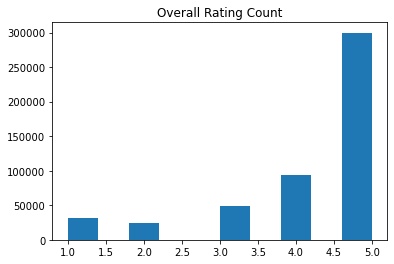

In [75]:
plt.hist(surprise_df['overall'])
plt.title('Overall Rating Count');

In [76]:
surprise_df['asin'].value_counts()

B00178630A    1381
B000ZK9QCS     905
B000XJNTNS     834
B00JK00S0S     783
B000ZKA0J6     774
              ... 
B0017GLJWY       1
B0017YHYFM       1
B000WZ7OD4       1
B001584XZO       1
B0011W8DNW       1
Name: asin, Length: 17408, dtype: int64

### Trending Products Recommendation

In [77]:
# most rated products
ratings_prod_summary = surprise_df.groupby('asin')['overall'].agg(['count', 'mean', 'std'])
most_rated = ratings_prod_summary.sort_values(by='count', ascending=False)
most_rated.head(10)

,count,mean,std
asin,,,
B00178630A,1381,2.824765,1.650119
B000ZK9QCS,905,4.627624,0.814355
B000XJNTNS,834,4.631894,0.794634
B00JK00S0S,783,4.690932,0.863590
B000ZKA0J6,774,3.560724,1.548962
B0012N94WO,726,4.174931,1.100961
B003ZSP0WW,694,4.651297,0.819684
B00GODZYNA,684,4.644737,0.864690
B000ZK7ZOE,674,4.461424,0.847597


In [78]:
# trending products recommendation
print(f'Top selling and rating products: {most_rated.head(10).index.tolist()}')

Top selling and rating products: ['B00178630A', 'B000ZK9QCS', 'B000XJNTNS', 'B00JK00S0S', 'B000ZKA0J6', 'B0012N94WO', 'B003ZSP0WW', 'B00GODZYNA', 'B000ZK7ZOE', 'B000P46NMA']


In [79]:
df_just_prod = df_prod[['asin', 'title', 'description', 'brand', 'imageURL']]

In [80]:
df_just_prod.loc[df_prod['asin'].isin(most_rated.head(10).index.tolist())]

,asin,title,description,brand,imageURL
34644,B000P46NMA,Assassin's Creed - Playstation 3,"Video Games,PlayStation 3,Games,",Ubisoft,[https://images-na.ssl-images-amazon.com/image...
36938,B000XJNTNS,Mario Kart Wii with Wii Wheel,"Video Games,Wii,Accessories,Controllers,Racing...",Nintendo,[https://images-na.ssl-images-amazon.com/image...
37219,B000ZK7ZOE,inFAMOUS - Playstation 3,"Video Games,PlayStation 3,Games,",Sony,[https://images-na.ssl-images-amazon.com/image...
37225,B000ZK9QCS,God of War III - Playstation 3,"Video Games,PlayStation 3,Games,",Sony,[https://images-na.ssl-images-amazon.com/image...
37226,B000ZKA0J6,StarCraft II: Wings of Liberty,"Video Games,PC,Games,",Blizzard Entertainment,[https://images-na.ssl-images-amazon.com/image...
37754,B0012N94WO,Resident Evil 5 - Playstation 3,"Video Games,PlayStation 3,Games,",Capcom,[https://images-na.ssl-images-amazon.com/image...
38709,B00178630A,Diablo III,"Video Games,PC,",Blizzard Entertainment,[https://images-na.ssl-images-amazon.com/image...
47584,B003ZSP0WW,Xbox 360 Wireless Controller - Glossy Black,"Video Games,Xbox 360,Accessories,Controllers,G...",Microsoft,[https://images-na.ssl-images-amazon.com/image...
62781,B00GODZYNA,Uncharted 4: A Thief's End - PlayStation 4,"Video Games,PlayStation 4,Games,",Sony,[https://images-na.ssl-images-amazon.com/image...
65843,B00JK00S0S,The Last of Us Remastered - PlayStation 4,"Video Games,PlayStation 4,Games,",Sony,[https://images-na.ssl-images-amazon.com/image...


In [94]:
ratings_user_summary = surprise_df.groupby('reviewerID')['overall'].agg(['count', 'mean', 'std'])
ratings_user_summary.head()

,count,mean,std
reviewerID,,,
A0059486XI1Z0P98KP35,5,5.000000,0.000000
A0220159ZRNBTRKLG08H,6,4.666667,0.816497
A0266076X6KPZ6CCHGVS,14,5.000000,0.000000
A0277912HT4JSJKVSL3E,10,4.500000,0.707107
A02836981FYG9912C66F,7,3.714286,0.951190


## Collaborative Filtering

### Baseline

In [81]:
read = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(surprise_df, read)
train_df, test_df = train_test_split(surprise_data, random_state=42)

In [82]:
train_df

In [83]:
baseline_model1 = NormalPredictor()
baseline_model1.fit(train_df)

In [84]:
prediction1 = baseline_model1.test(test_df)

In [85]:
accuracy.rmse(prediction1)

RMSE: 1.5167


1.5166721385149788

In [86]:
baseline_model2 = BaselineOnly()
baseline_model2.fit(train_df)

Estimating biases using als...


In [87]:
predictions2 = baseline_model2.test(test_df)

In [88]:
accuracy.rmse(predictions2)

RMSE: 1.0447


1.0446509835320532

### KNN

In [106]:
knnbasic_cv = cross_validate(KNNBasic(), surprise_data, cv=5, verbose=False)
knnmeans_cv = cross_validate(KNNWithMeans(), surprise_data, cv=5, verbose=False)
knnz_cv = cross_validate(KNNWithZScore(), surprise_data, cv=5, verbose=False)

Computing the msd similarity matrix...


MemoryError: Unable to allocate 22.5 GiB for an array with shape (54899, 54899) and data type float64

In [121]:
knnbasic = KNNBasic()
knnbasic.fit(train_df)

Computing the msd similarity matrix...


MemoryError: Unable to allocate 22.7 GiB for an array with shape (55216, 55216) and data type float64

### SVD

In [89]:
# use default hyper parameters
svd = SVD(random_state=42)
svd.fit(train_df)
prediction_svd = svd.test(test_df)
accuracy.rmse(prediction_svd)

RMSE: 1.0152


1.0151596982698952

In [26]:
svd.predict('A1HP7NVNPFMA4N', '0700026657')

Prediction(uid='A1HP7NVNPFMA4N', iid='0700026657', r_ui=None, est=4.454239721476054, details={'was_impossible': False})

In [111]:
param_grid = {'n_factors':[20,50,100,150],'n_epochs':[10,20,30],'biased':[True,False]}
svd_grid_search = GridSearchCV(algo_class=SVD, param_grid=param_grid, measures=['rmse'], cv=5)
result1 = svd_grid_search.fit(surprise_data)

In [114]:
joblib.dump(svd_grid_search, 'svd_grid.pkl')

['svd_grid.pkl']

In [90]:
svd_loaded = joblib.load('svd_grid.pkl')

In [91]:
best_svd_algo = svd_loaded.best_estimator['rmse']

In [92]:
svd_loaded.best_params

{'rmse': {'n_factors': 50, 'n_epochs': 30, 'biased': True}}

In [93]:
best_svd_algo.fit(train_df)

In [252]:
predictions = best_svd_algo.test(test_df)
accuracy.rmse(predictions)

RMSE: 1.0051


1.0050677699707218

In [253]:
svd_best_param = SVD(n_factors=50, n_epochs=30, biased='True', random_state=42)
svd_best_param.fit(train_df)

In [254]:
svd_best_param.test(test_df)
predictions = svd_best_param.test(test_df)
accuracy.rmse(predictions)

RMSE: 1.0029


1.0029432416894384

grid search on smaller n_factors and larger n_epochs

In [369]:
parm_grid = {'n_factors':[2,5,10,20],'n_epochs':[50,70,100],'biased':[True,False]}

In [370]:
svd_grid_search2 = GridSearchCV(algo_class=SVD,param_grid=parm_grid,measures=['rmse'],cv=5)
result2 = svd_grid_search2.fit(surprise_data)

In [371]:
joblib.dump(svd_grid_search2, 'svd_grid_nfactor.pkl')

['svd_grid_nfactor.pkl']

In [372]:
svd_loaded2 = joblib.load('svd_grid_nfactor.pkl')

In [375]:
svd_loaded2.best_params

{'rmse': {'n_factors': 20, 'n_epochs': 50, 'biased': True}}

In [376]:
svd_best_param2 = SVD(n_factors=20, n_epochs=50, biased='True', random_state=42)
svd_best_param2.fit(train_df)

In [377]:
svd_best_param2.test(test_df)
predictions = svd_best_param2.test(test_df)
accuracy.rmse(predictions)

RMSE: 1.0055


1.0054501834755718

grid search learning rate

In [94]:
param_grid = {'n_factors':[20,50,100,150], 'n_epochs':[10,20,30], 'lr_all':[0.003,0.005,0.01,0.02]}

In [96]:
svd_grid_search3 = GridSearchCV(algo_class=SVD, param_grid=param_grid, measures=['rmse'], cv=5)
result3 = svd_grid_search3.fit(surprise_data)

In [97]:
joblib.dump(svd_grid_search3, 'svd_grid_lr.pkl')

['svd_grid_lr.pkl']

In [98]:
svd_loaded3 = joblib.load('svd_grid_lr.pkl')

In [100]:
svd_loaded3.best_params

{'rmse': {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.02}}

In [103]:
svd_best_param3 = SVD(n_factors=150, n_epochs=30, biased='True', lr_all=0.02, random_state=42)
svd_best_param3.fit(train_df)

In [104]:
svd_best_param3.test(test_df)
predictions = svd_best_param3.test(test_df)
accuracy.rmse(predictions)

RMSE: 0.9981


0.9981241292377293

### SVDpp

In [118]:
# use default hyper parameters
svdpp = SVDpp(random_state=42)
svdpp.fit(train_df)
predictions_def = svdpp.test(test_df)
accuracy.rmse(predictions_def)

RMSE: 1.0074


1.0073771519138817

In [119]:
joblib.dump(predictions_def, 'svdpp_def.pkl')

['svdpp_def.pkl']

In [120]:
svdpp_def_loaded = joblib.load('svdpp_def.pkl')

In [121]:
accuracy.rmse(svdpp_def_loaded)

RMSE: 1.0074


1.0073771519138817

In [ ]:
param_grid = {'n_factors':[20,50], 'n_epochs':[20,50], 'lr_all':[0.005,0.01], 'reg_all':[0.02, 0.05]}
svdpp_grid_search = GridSearchCV(algo_class=SVDpp, param_grid=param_grid, measures=['rmse'], cv=5)
result_svdpp1 = svdpp_grid_search.fit(surprise_data)

I was going to do some grid searches on SVDpp algorithm as well like SVD, but the grid search process takes too long to be finished due to my computer's computational capability. So I will just do some random tuning below and try to get the lowest rmse as I can.

In [126]:
svdpp1 = SVDpp(n_factors=50, n_epochs=50, lr_all=0.005, reg_all=0.005)
svdpp1.fit(train_df)
predictions1 = svdpp1.test(test_df)
accuracy.rmse(predictions1)

RMSE: 1.0362


1.036242671479692

In [123]:
joblib.dump(predictions1, 'svdpp1.pkl')

['svdpp1.pkl']

In [124]:
svdpp1_loaded = joblib.load('svdpp1.pkl')

In [125]:
accuracy.rmse(svdpp1_loaded)

RMSE: 1.0329


1.0329479058203719

In [128]:
svdpp2 = SVDpp(n_factors=10, n_epochs=10, lr_all=0.005, reg_all=0.005)
svdpp2.fit(train_df)
predictions2 = svdpp2.test(test_df)
accuracy.rmse(predictions2)

RMSE: 1.0454


1.0453575370720092

In [129]:
joblib.dump(predictions2, 'svdpp2.pkl')

['svdpp2.pkl']

In [131]:
svdpp2_loaded = joblib.load('svdpp2.pkl')

In [132]:
accuracy.rmse(svdpp2_loaded)

RMSE: 1.0454


1.0453575370720092